In [118]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



In [119]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [120]:
# from forest.victims.models import get_model
# from forest.victims.models import resnet_picker
# model = get_model('ResNet18', 'CIFAR10', load_model="/home/brady/anomaly_detection/models/clean_model/full_epoch_30.pth")


#load pretrained model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features


#modify output layer for 2 classes - for this case the classes are regular frogs and noisy frogs
#but for the project it would be poisoned vs non-poisoned images
model.fc = torch.nn.Linear(num_ftrs, 2)



In [121]:
#freeze earlier layers - this is optional and it may work better to NOT freeze the earlier layers
# for param in model.parameters():
#     param.requires_grad = False
#     for name, param in model.named_parameters():
#         if "fc" in name:
#             param.requires_grad = True 


In [122]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


trainset = torchvision.datasets.ImageFolder(root="data/noisy_vs_clean/train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root="data/noisy_vs_clean/test",transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)


EPOCHS=40
BATCH_SIZE = 32
TOTAL_SIZE = 9800
#TOTAL_TEST_SIZE = 
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE

TOTAL_TEST_SIZE = 200 
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [123]:
trainset

Dataset ImageFolder
    Number of datapoints: 9800
    Root location: data/noisy_vs_clean/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [124]:
trainset.classes

['cleanfrog', 'realNoisyFrogs']

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0007
)  # lr should be kept low so that the pre-trained weights don't change easily

In [126]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(testloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            # for i in range(BATCH_SIZE):
            for i in range(len(data)):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )

In [127]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 83 INCORRECT: 109 TEST ACCURACY: 0.4322916666666667
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.4322916666666667 LOSS : 0.9779199461142222


In [128]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []


loss_history = []
accuracy_history = []

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model(data)
        # loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss = criterion(output, target.long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        # for p in range(BATCH_SIZE):
        for p in range(len(data)):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model.state_dict(), "model_save/model.pth") # Saving our best model


-----------------------EPOCH 0 -----------------------------------
 EPOCH 0 MINIBATCH: 305/306 LOSS: tensor(0.6806, device='cuda:0') 
 EPOCH 0 LOSS tensor(0.7305, device='cuda:0') ETA: 5.7790937423706055 
 MAX LOSS: tensor(1.6805, device='cuda:0') MIN LOSS: tensor(0.6142, device='cuda:0') TRAIN ACCURACY: 0.5052083333333334
CORRECT: 92 INCORRECT: 100 TEST ACCURACY: 0.4791666666666667
-----------------------EPOCH 1 -----------------------------------
 
 EPOCH 1 LOSS tensor(0.6829, device='cuda:0') ETA: 4.547728776931763 
 MAX LOSS: tensor(0.8528, device='cuda:0') MIN LOSS: tensor(0.5386, device='cuda:0') TRAIN ACCURACY: 0.5650531045751634
CORRECT: 121 INCORRECT: 71 TEST ACCURACY: 0.6302083333333334
-----------------------EPOCH 2 -----------------------------------
 EPOCH 2 MINIBATCH: 305/306 LOSS: tensor(0.6914, device='cuda:0') 
 EPOCH 2 LOSS tensor(0.7082, device='cuda:0') ETA: 5.025978088378906 
 MAX LOSS: tensor(0.8834, device='cuda:0') MIN LOSS: tensor(0.6007, device='cuda:0') TRAIN

In [129]:
print("ACCURACY : ",new_best)

ACCURACY :  0.9791666666666666


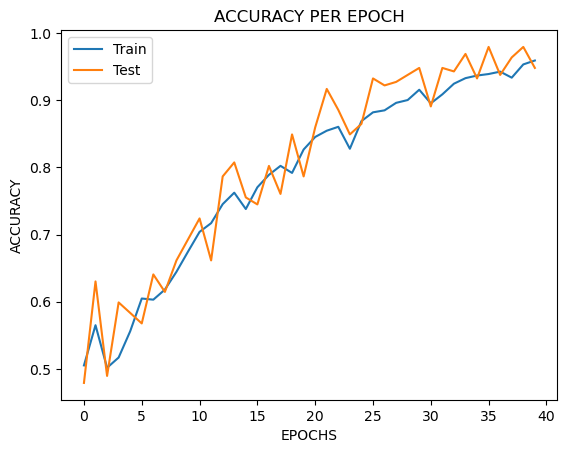

In [130]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()

In [131]:
from PIL import Image

# Load the best saved model
model.load_state_dict(torch.load("model_save/model.pth"))
model.eval()  # Set the model to evaluation mode

# Directory containing all images
allfrog_dir = "data/allfrog"  # Replace with the actual path to your "allfrogs" folder
image_files = sorted(os.listdir(allfrog_dir))  # Lexicographical ordering

# Prepare the transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Counters for labels
good_count = 0
bad_count = 0

# Perform predictions and write labels to file
output_file = "labels/labels.txt"
with open(output_file, "w") as f:
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(allfrog_dir, image_file)
        # Open the image
        image = Image.open(image_path).convert("RGB")  # Ensure 3 channels
        # Apply the transformation
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            # Map predictions to "good" or "bad"
            label = "good" if predicted.item() == 0 else "bad"
            f.write(label + "\n")

            # Update counters
            if label == "good":
                good_count += 1
            else:
                bad_count += 1

        # Print the counters dynamically
        print(f"\rgood: {good_count} bad: {bad_count}", end="")
print("\nLabels written to", output_file)


good: 4951 bad: 549
Labels written to labels/labels.txt
